<a href="https://colab.research.google.com/github/chrismartel/ECSE415-Project-G7/blob/main/classification/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Download ECSE415 Vehicle Dataset

In [35]:
!wget -O output https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1
!mv output dataset.zip
!unzip dataset.zip
!rm dataset.zip

--2022-03-31 18:46:23--  https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1
Resolving mcgill-my.sharepoint.com (mcgill-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to mcgill-my.sharepoint.com (mcgill-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/raghav_mehta_mail_mcgill_ca/Documents/dataset.zip?ga=1 [following]
--2022-03-31 18:46:24--  https://mcgill-my.sharepoint.com/personal/raghav_mehta_mail_mcgill_ca/Documents/dataset.zip?ga=1
Reusing existing connection to mcgill-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 826880986 (789M) [application/x-zip-compressed]
Saving to: ‘output’

output                0%[                    ]   2.52M  2.49MB/s               ^C
Archive:  dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes

###Download car dataset from Stanford University

In [ ]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
!tar -xf cars_test.tgz

--2022-03-31 17:10:05--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  18.8MB/s    in 59s     

2022-03-31 17:11:04 (15.8 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [36]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv

def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   True,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)
  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)
  if bbox: 
    if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
        for (_,x1,y1,x2,y2) in bbox:
            cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
    else:
        _,x1,y1,x2,y2 = bbox
        cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
  
  return annotated

In [37]:
def intersection(r1, r2):
  '''
      Compute intersection rectangle of two rectangles

      r1: tuple (x1,y1,x2,y2) coordinates of rectangle 1
      r2: tuple (x1,y1,x2,y2) coordinates of rectangle 2

      return area interesction rectangle
  '''
  # x axis

  # r2 in r1
  if r1[0] <= r2[0] and r1[2] >= r2[2]:
    x1, x2 = r2[0], r2[2]

  # r1 in r2
  elif r2[0] <= r1[0] and r2[2] >= r1[2]:
    x1, x2 = r1[0], r1[2]

  # r1 left of r2 and overlap
  elif r1[0] <= r2[0] and r1[2] >= r2[0]:
    x1, x2 = r2[0], r1[2]

  # r2 left of r1 and overlap
  elif r2[0] <= r1[0] and r2[2] >= r1[0]:
    x1, x2 = r1[0], r2[2]

  # no overlap
  else:
    return None

  # y axis

  # r2 in r1
  if r1[1] <= r2[1] and r1[3] >= r2[3]:
    y1, y2 = r2[1], r2[3]

  # r1 in r2
  if r2[1] <= r1[1] and r2[3] >= r1[3]:
    y1, y2 = r1[1], r1[3]

  # r1 top of r2 and overlap
  elif r1[1] <= r2[1] and r1[3] >= r2[1]:
    y1, y2 = r2[1], r1[3]

  # r2 top of r1 and overlap
  elif r2[1] <= r1[1] and r2[3] >= r1[1]:
    y1, y2 = r1[1], r2[3]

  # no overlap
  else:
    return None

  return int(x1), int(y1), int(x2), int(y2)


def area(r):
  '''
      Rectangle area

      r: tuple (x1,y1,x2,y2) coordinates of rectangle
      
      return area
  '''
  return (r[2]-r[0])*(r[3]-r[1])

##**Build Dataset**


Positive samples are obtained from the bounding box provided in the 4 image sequences from the ECSE415 dataset and from the car images from the Stanford University dataset.

Negative samples are obtained by generating random patches which intersect minimally with vehicles from the 4 image sequences from the ECSE415 dataset.

In [38]:
from matplotlib.cbook import maxdict
import os
import cv2 as cv
import os
from random import randint, shuffle, choice

def build_dataset(positive_negative_ratio=1, min_intersection_ratio=0.8, use_external_vehicle_samples=False, number_of_external_vehicle_samples=500):
  '''
      Build a dataset from provided image sequences and other external datasets. The built dataset consists of a 
      dictionary. Each key corresponds to a sequence of images. The image sequences can be split and used for training.

      positive_negative_ratio: The ratio of number of positive samples versus negative to generate in the dataset.
      min_intersection_ratio: The minimum ratio of a random generated patch vs. a vehicle bbox to be considered a vehicle
      use_external_vehicle_samples: indicates if external data must be used.

      return sequences, a dictionary containing list of images in each sequence.
  '''

  # Build sequence dictionary
  number_of_sequences = 4
  sequences = dict()
  for i in range(number_of_sequences):
    sequences[i] = list()

  number_of_positive_samples = 0


  # -------------------- Positive Train Set -------------------- #

  for seq_id in range(number_of_sequences):
    visited_ids = list() # keep track of vehicle ids to avoid adding the same vehicle multiple times

    bboxes = parse('dataset/000{seq_id}.txt'.format(seq_id=seq_id))

    # Get positive samples from provided bounding boxes
    for frame_id, frame_bboxes in bboxes.items():
      img = cv.imread('dataset/000{seq_id}/{frame_id:06d}.png'.format(seq_id=seq_id, frame_id=frame_id))
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

      for bbox in frame_bboxes:
        id, x1, y1, x2, y2 = bbox.astype('int32')

        if id not in visited_ids:
          visited_ids.append(id)
          bbox_img = img[y1:y2,x1:x2]
          sequences[seq_id].append((bbox_img,1))
          number_of_positive_samples += 1

  # Add Car Images from Stanford University dataset
  if use_external_vehicle_samples:
    external_dataset_length = len(os.listdir('cars_test'))

    inds = list(range(external_dataset_length))
    shuffle(inds)

    for i in range(number_of_external_vehicle_samples):
      img_id = inds[i]
      img = cv.imread("cars_test/{img_id:05d}.jpg".format(img_id=img_id))

      random_sequence_id = choice(list(range(number_of_sequences)))
      sequences[random_sequence_id].append((img,1))
      number_of_positive_samples += 1

  # -------------------- Negative Train Set -------------------- #

  # Random patches constraints
  minimum_bbox_h, maximum_bbox_h = 0.1, 0.5
  minimum_bbox_w, maximum_bbox_w = 0.1, 0.5
  max_diff_width_height = 30

  negative_samples_set_length = int((1 / positive_negative_ratio) * number_of_positive_samples)
  number_of_negative_samples_per_sequence = int(negative_samples_set_length/number_of_sequences)

  for seq_id in range(number_of_sequences):

    bboxes = parse('dataset/000{seq_id}.txt'.format(seq_id=seq_id))
    # Generate negative samples
    for sample in range(number_of_negative_samples_per_sequence):

      frame_id = choice(list(bboxes.keys()))
      frame_bboxes = bboxes[frame_id]
      
      img = cv.imread('dataset/000{seq_id}/{frame_id:06d}.png'.format(seq_id=seq_id, frame_id=frame_id))
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

      # Generate valid dimensions
      while(True):
        random_y1 = randint(0,img.shape[0])
        random_y2 = randint(random_y1,img.shape[0])

        random_x1 = randint(0,img.shape[1])
        random_x2 = randint(random_x1,img.shape[1])

        # validate dimensions
        if random_y2 - random_y1 < minimum_bbox_h*img.shape[0] or random_y2 - random_y1 > maximum_bbox_h*img.shape[0] :
          continue
        if random_x2 - random_x1 < minimum_bbox_w*img.shape[1] or random_x2 - random_x1 > maximum_bbox_w*img.shape[1] :
          continue

        if abs((random_x2 - random_x1) - (random_y2 - random_y1)) > max_diff_width_height:
          continue
        break

      random_bbox = (random_x1, random_y1, random_x2, random_y2)
      random_area = area(random_bbox)

      # check intersection with vehicles
      is_vehicle = 0
      for (id, x1,y1,x2,y2) in frame_bboxes:
        vehicle_bbox = (x1,y1,x2,y2)
        vehicle_area = area(vehicle_bbox)

        intersection_bbox = intersection(vehicle_bbox, random_bbox)
        
        # no intersection
        if intersection_bbox is None:
          continue
        else:
          intersection_area = area(intersection_bbox)
          # check for minimal intersection
          if intersection_area/vehicle_area > min_intersection_ratio and intersection_area/random_area > min_intersection_ratio:       
            is_vehicle = 1
            break

      random_bbox_img = img[random_y1:random_y2,random_x1:random_x2]
      if is_vehicle == 0:
        sequences[seq_id].append((random_bbox_img,is_vehicle))

  return sequences

###**Dataset Statistics**

In [39]:
import numpy as np

def dataset_statistics(sequences, statistic_types):
  '''
      Collect width, height, and aspect ratios statistics from image dataset.

      sequences: dictionary storing images per sequence. Keys are sequence ids and values are
                lists of images.
      
      statistics: list containing the statistics to compute. Can contain the following values: 'width', 'height',
                  'aspect_ratio', 'class_distribution'.
      
      return a dictionary of statistics. For height, width, and aspect ratio, the value is a min-max tuple.
                                         For class_distribution, the value is an array of counts per class.
  '''
  # Number of samples
  number_of_samples = 0
  for seq in sequences.values():
    number_of_samples += len(seq)

  # Class distribution
  if 'class_distribution' in statistic_types:
    class_count = np.zeros(2)

  # compute statistics on full image dataset
  if 'aspect_ratio' in statistic_types:
    aspect_ratios = np.zeros(number_of_samples)
    min_aspect_ratio, max_aspect_ratio = np.iinfo(np.int32).max, 0

  if 'width' in statistic_types:
    widths = np.zeros(number_of_samples)
    min_width, max_width = np.iinfo(np.int32).max, 0

  if 'height' in statistic_types:
    heights = np.zeros(number_of_samples)
    min_height, max_height = np.iinfo(np.int32).max, 0

  for seq in sequences.values():
    for i, sample in enumerate(seq):
      if 'width' in statistic_types:
        widths[i] = sample[0].shape[1]
        min_width = widths[i] if widths[i] < min_width else min_width
        max_width = widths[i] if widths[i] > max_width else max_width

      if 'height' in statistic_types:
        heights[i] = sample[0].shape[0]
        min_height = heights[i] if heights[i] < min_height else min_height
        max_height = widths[i] if widths[i] > max_height else max_height

      if 'aspect_ratio' in statistic_types:
        aspect_ratios[i] = heights[i] / float(widths[i])
        min_aspect_ratio = aspect_ratios[i] if aspect_ratios[i] < min_aspect_ratio else min_aspect_ratio
        max_aspect_ratio = aspect_ratios[i] if aspect_ratios[i] > max_aspect_ratio else max_aspect_ratio
      
      if 'class_distribution' in statistic_types:
        class_count[sample[1]] += 1

  stats = dict()
  if 'width' in statistic_types:
    stats['width'] = (min_width, max_width)
  
  if 'height' in statistic_types:
    stats['height'] = (min_height, max_height)

  if 'aspect_ratio' in statistic_types:
    stats['aspect_ratio'] = (min_aspect_ratio, max_aspect_ratio)

  if 'class_distribution' in statistic_types:
    stats['class_distribution'] = class_count
  
  return stats

In [40]:
# Dataset parameters
#number_of_negative_samples_per_sequence = 200
positive_negative_ratio=1
min_intersection_ratio = 0.8
use_external_vehicle_samples = True
number_of_external_vehicle_samples = 500

# Build Dataset
sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, use_external_vehicle_samples=use_external_vehicle_samples, number_of_external_vehicle_samples=number_of_external_vehicle_samples)

# Compute Image Statistics
statistics = dataset_statistics(sequences, ['width','height','aspect_ratio','class_distribution'])

min_aspect_ratio, max_aspect_ratio = statistics['aspect_ratio']
min_height, max_height = statistics['height']
min_width, max_width = statistics['width']
class_count = statistics['class_distribution']

aspect_ratio_interval = max_aspect_ratio - min_aspect_ratio
width_interval = int(max_width - min_width)
height_interval = int(max_height - min_height)

aspect_ratio_banks = range(int(min_aspect_ratio*100), int(max_aspect_ratio*100), int(aspect_ratio_interval*100))
width_banks = range(int(min_width), int(max_width), width_interval)
height_banks = range(int(min_height), int(max_height), height_interval)

# TODO display number of instances in each range


# Display Class Distribution
plt.figure(figsize=(5,5))
plt.bar(['Non-Vehicles','Vehicles'],class_count, width=0.3)
plt.ylabel('Quantity')
plt.title("Class Distribution")
plt.show()

KeyboardInterrupt: ignored

##**Image Preprocessing**



*   Resize Images
*   Normalize Images
*   Extract HoG Features
*   Add Noise?






In [45]:
from skimage.transform import resize
from skimage.feature import hog
import numpy as np
from random import shuffle
import time

def preprocess_image(image, resize_shape, orientations, pixels_per_cell, cells_per_block, preprocessing_time=False):
  '''
  Preprocess an image.

  sequences: dict - Each key contains a list of tuples. Each tuple has the following format (np.array(h,w,3), integer label)
  resize_shape: tuple (new_height, new_width) - resizing shape
  orientations: int - number of orientation bins in hog feature computations
  pixels_per_cells: tuple (h,w) - number of pixels per cell in hog feature computation
  cells_per_block: tuple (h,w) - number of cells per block in hog feature computation
  preprocessing_time: indicates if preprocessing time must be computed and returned

  return (features (optional)time) - HoG features extracted from the image
  '''
  start = time.time()

  # Resize image
  resized = resize(image, resize_shape)

  # Min-max normalization
  min, max = np.min(resized), np.max(resized)
  normalized = (resized - min) / (max - min)

  # Extract HoG features
  feature = hog(normalized, orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True, multichannel=True)

  end = time.time()

  if preprocessing_time:
    return feature, (end-start)
  else:
    return feature

def preprocess_sequences(sequences, resize_shape, orientations, pixels_per_cell, cells_per_block, preprocessing_time=False):
  '''
  Preprocess a series of extracted image from image sequences sequence. 

  sequences: dict - Each key contains a list of tuples. Each tuple has the following format (np.array(h,w,3), integer label)
  resize_shape: tuple (new_height, new_width) - resizing shape
  orientations: int - number of orientation bins in hog feature computations
  pixels_per_cells: tuple (h,w) - number of pixels per cell in hog feature computation
  cells_per_block: tuple (h,w) - number of cells per block in hog feature computation

  return (features, labels) - features and labels are dict. Each key represents the sequence id.
  '''
  number_of_sequences = len(sequences.keys())

  if preprocessing_time:
    count = 0
    time_sum = 0

  # compute number of hog features
  number_hog_features = len(hog(np.zeros(resize_shape), orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True))
  
  features = dict()
  labels = dict()

  for i, seq in enumerate(sequences.values()):
    number_of_samples = len(seq) # number of image samples in sequence

    seq_features = np.zeros((number_of_samples, number_hog_features)) # x
    seq_labels = np.zeros(number_of_samples) # y

    for j, (sample, label) in enumerate(seq):

      # Extract HoG features
      seq_labels[j] = label

      if preprocessing_time:
        seq_features[j], time = preprocess_image(sample, resize_shape, orientations, pixels_per_cell, cells_per_block, preprocessing_time=preprocessing_time)
        count += 1
        time_sum += time
      else:
        seq_features[j] = preprocess_image(sample, resize_shape, orientations, pixels_per_cell, cells_per_block, preprocessing_time=preprocessing_time)

    features[i] = seq_features
    labels[i] = seq_labels

  if preprocessing_time:
    return features, labels, (time_sum/count)
  else:
    return features, labels



###**3-Fold Cross-Validation**

For each validation, choose an image sequence to be the validation set

In [42]:
# Performance Measures

def accuracy(tp, fp, tn, fn):
  return 100*(tp+tn)/(tp+fp+tn+fn)

def precision(tp, fp):
  return 100*tp/(tp+fp)

def recall(tp, fn):
  return 100*tp/(tp+fn)

In [43]:
from random import shuffle
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
import time

"""
Perform 3-fold cross-validation for training SVM classifier for vehicle detection.
features: dictionary where keys are the image sequences ids and values are numpy arrays of features.
labels: dictionary where keys are the image sequences ids and value are numpy arrays of labels (1 for vehicle, 0 for non-vehcile)
K: number of folds. Must be a value between 1 and number of sequences.
C: parameter used for SVM training.
Return accuracies, recalls, precisions and inference execution time for each fold.
"""
def cross_validation(features, labels, C=10, bagging=False, n_estimators=10):
  # 3-Fold Cross Validation
  K=3

  # Performance measures
  tp, fp, tn, fn = np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K)

  accuracies, recalls, precisions, inference_execution_times =  np.zeros(K),  np.zeros(K),  np.zeros(K),  np.zeros(K)

  for k in range(K):
    # val dataset
    x_val, y_val = features[k], labels[k]

    # train dataset
    train_range = list(range(0,k)) + list(range(k+1,K))
    x_train, y_train = None, None
    for i in train_range:
      if x_train is None:
        x_train = features[i]
      else:
        x_train = np.concatenate((x_train, features[i]), axis=0)

      if y_train is None:
        y_train = labels[i]
      else:
        y_train = np.concatenate((y_train, labels[i]), axis=0)

    # Bagging classifier
    if bagging:
      clf = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C), n_estimators=n_estimators, random_state=None)

    # SVM Binary Classifier
    else:
      clf = svm.SVC(gamma='scale', C=C)
          
    # Train
    clf.fit(x_train, y_train)

    # Predict
    start = time.time()
    y_pred = clf.predict(x_val)
    end = time.time()
    inference_execution_times[k] = (end-start)

    # Performance measurements
    tp[k] = np.sum(np.logical_and(y_pred == 1, y_val == 1))
    fp[k] = np.sum(np.logical_and(y_pred == 1, y_val == 0))
    tn[k] = np.sum(np.logical_and(y_pred == 0, y_val == 0))
    fn[k] = np.sum(np.logical_and(y_pred == 0, y_val == 1))

    accuracies[k] = accuracy(tp[k], fp[k], tn[k], fn[k])
    recalls[k] = recall(tp[k], fn[k])
    precisions[k] = precision(tp[k], fp[k])

  return accuracies, recalls, precisions, inference_execution_times

###**Inference on Test Set**

In [46]:
# Dataset parameters
min_intersection_ratio = 0.8
use_external_vehicle_samples = True
number_of_external_vehicle_samples = 800

# Preprocessing parameters
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
C = 10
bagging = False
n_estimators = 1

# Build Dataset
sequences = build_dataset(min_intersection_ratio=min_intersection_ratio, use_external_vehicle_samples=use_external_vehicle_samples, number_of_external_vehicle_samples=number_of_external_vehicle_samples)

# Preprocess
features, labels = preprocess_sequences(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)


# Build Train set: sequences 0, 1 and 2
x_train, y_train = None, None
for i in range(3):
  if x_train is None:
    x_train = features[i]
  else:
    x_train = np.concatenate((x_train,features[i]),axis=0)

  if y_train is None:
    y_train = labels[i]
  else:
    y_train = np.concatenate((y_train,labels[i]),axis=0)

# Test set: sequence 3
x_test, y_test = features[3], labels[3]

# Bagging classifier
if bagging:
  clf = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C), n_estimators=n_estimators, random_state=None)

# SVM Binary Classifier
else:
  clf = svm.SVC(gamma='scale', C=C)

# Train
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

tp = np.sum(np.logical_and(y_pred == 1, y_test == 1))
fp = np.sum(np.logical_and(y_pred == 1, y_test == 0))
tn = np.sum(np.logical_and(y_pred == 0, y_test == 0))
fn = np.sum(np.logical_and(y_pred == 0, y_test == 1))

print("recall: ",recall(tp,fn))
print("accuracy: ",accuracy(tp,fp, tn,fn))
print("precision: ",precision(tp,fp))

recall:  93.42105263157895
accuracy:  95.8695652173913
precision:  98.15668202764977


###Display 5 Vehicles and 5 Non-Vehicles

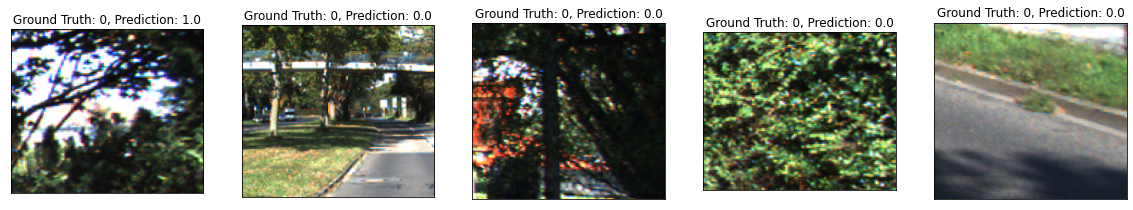

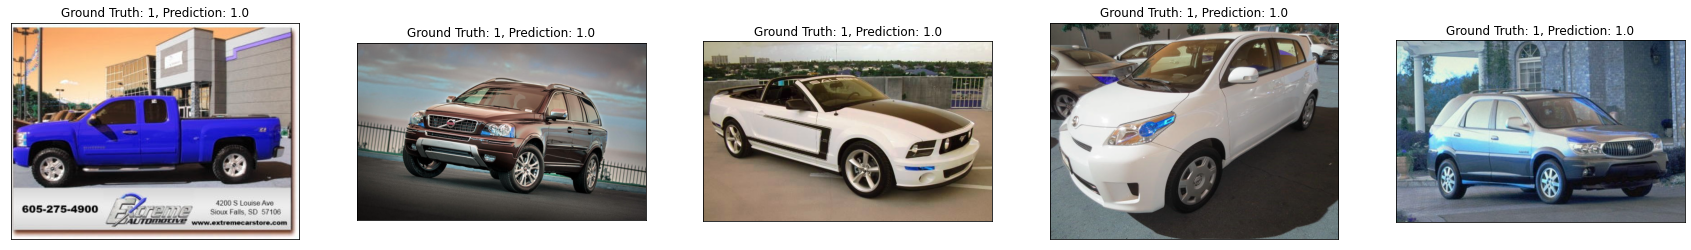

In [ ]:
# Display Non_vehicules
fig, axes = plt.subplots(1,5)
fig.set_figheight(8)
fig.set_figwidth(20)

visited = list()
for i in range(5):
  while(True):
    sequence_id = 3
    image_id = randint(0,len(sequences[sequence_id])-1)
    
    true_label = sequences[sequence_id][image_id][1]
    if true_label == 1:
      continue

    if image_id in visited:
      continue
    
    axes[i].set_title("Ground Truth: {true}, Prediction: {pred}".format(true=true_label, pred=y_pred[image_id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(sequences[sequence_id][image_id][0])
    visited.append(image_id)
    break

plt.show()

# Display 5 Vehicules
fig, axes = plt.subplots(1,5)
fig.set_figheight(10)
fig.set_figwidth(30)

visited = list()
for i in range(5):
  while(True):
    sequence_id = 3
    image_id = randint(0,len(sequences[sequence_id])-1)

    true_label = sequences[sequence_id][image_id][1]
    if true_label == 0:
      continue

    if image_id in visited:
      continue
    
    axes[i].set_title("Ground Truth: {true}, Prediction: {pred}".format(true=true_label, pred=y_pred[image_id]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(sequences[sequence_id][image_id][0])
    visited.append(image_id)
    break

plt.show()

###Experiment 1: Single Cross-Validation With Best Hyper-Parameters

In [ ]:
# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8
use_external_vehicle_samples = True


# Preprocessing parameters
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
C = 10
bagging = False
n_estimators = 1

# Build Dataset
sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, use_external_vehicle_samples=use_external_vehicle_samples)

# Preprocess
features, labels = preprocess_sequences(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)

# CV
accuracies, recalls, precisions, inference_exec_times = cross_validation(features, labels, C=C, bagging=bagging, n_estimators=n_estimators)

# Results
print("recall: {recall:.4f}%, std: {std:.4f}".format(recall=np.mean(recalls), std=np.std(recalls)))
print("accuracy: {acc:.4f}%, std: {std:.4f}".format(acc=np.mean(accuracies),std=np.std(accuracies)))
print("precision: {precision:.4f}%, {std:.4f}".format(precision=np.mean(precisions), std=np.std(precisions)))
print("Inference Execution Time: {t}s".format(t=np.mean(inference_exec_times)))

recall: 85.0247% std: 12.3078
accuracy: 85.5002% std: 5.5719
precision: 87.5930% 4.7267
Inference Execution Time: 0.5308928489685059s


### **Hyper-Parameter Tuning**

#### Param 1: Positive negative ratio

In [44]:
# Dataset parameters
min_intersection_ratio = 0.8
use_external_vehicle_samples = True
number_of_external_vehicle_samples = 500

# Preprocessing parameters
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 1
param_range = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 2]

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

for i, positive_negative_ratio in enumerate(param_range):
  # Build Dataset
  sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_external_vehicle_samples=number_of_external_vehicle_samples, use_external_vehicle_samples=use_external_vehicle_samples)

  # Preprocess
  features, labels = preprocess_sequences(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)

  # CV
  acc, rec, prec, exec = cross_validation(features, labels, C=C, bagging=bagging, n_estimators=n_estimators)
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)


# Display
param_name = "Positive to Negative Ratio"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (s)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

AttributeError: ignored

#### Param 2: Parameter C

In [ ]:
# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8
use_external_vehicle_samples = True

# Preprocessing parameters
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
# C = 10
param_range = [0.01, 0.05, 0.1, 0.5, 1, 2, 3]

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, use_external_vehicle_samples=use_external_vehicle_samples)

# Preprocess
features, labels = preprocess_sequences(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)

# CV
for i, c in enumerate(param_range):
  acc, rec, prec, exec = cross_validation(features, labels, C=c, bagging=bagging, n_estimators=n_estimators)
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)


# Display
param_name = "C"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)

# Plot Accuracy
axes[0].scatter(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].scatter(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].scatter(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].scatter(param_range,inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (s)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

#### Param 3: Number of Estimators in Bagging

In [ ]:
# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8
use_external_vehicle_samples = True

# Preprocessing parameters
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = True
#n_estimators = 1
C = 10
param_range = [10, 20, 30, 40, 50, 60, 70, 80, 90 , 100]

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, use_external_vehicle_samples=use_external_vehicle_samples)

# Preprocess
features, labels = preprocess_sequences(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)

# CV
for i, n_estimators in enumerate(param_range):
  acc, rec, prec, exec = cross_validation(features, labels, C=C, bagging=bagging, n_estimators=n_estimators)
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)


# Display
param_name = "Number of Estimators"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)

# Plot Accuracy
axes[0].scatter(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].scatter(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].scatter(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].scatter(param_range,inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (s)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

###Param 4: HoG Block Shape

In [ ]:
# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8
use_external_vehicle_samples = True

# Preprocessing parameters
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell
# cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 10

param_range = [(1,1),(2,2),(2,3),(3,2),(3,3),(3,4),(4,3),(4,4)]

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, use_external_vehicle_samples=use_external_vehicle_samples)

for i, cells_per_block in enumerate(param_range):

  # Preprocess
  features, labels = preprocess_sequences(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)
  
  # CV
  acc, rec, prec, exec = cross_validation(features, labels, C=C, bagging=bagging, n_estimators=n_estimators)
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)


# Display
param_name = "Cells Per Block"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (s)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=np.min(inference_exec_times), param=param_range_str[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

###Param 5: HoG Cell Shape

In [ ]:
# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8
use_external_vehicle_samples = True

# Preprocessing parameters
W = 128
H = 80
orientations = 9 # number of orientation bins
# pixels_per_cell = (8,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 10

param_range = [(4,4),(4,6),(6,4),(6,6),(8,8), (8,16), (16,16)]

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, use_external_vehicle_samples=use_external_vehicle_samples)

for i, pixels_per_cell in enumerate(param_range):
  # Preprocess
  features, labels = preprocess_sequences(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)
  
  # CV
  acc, rec, prec, exec = cross_validation(features, labels, C=C, bagging=bagging, n_estimators=n_estimators)
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# Display
param_name = "Pixels Per Cell"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (s)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=np.min(inference_exec_times), param=param_range_str[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

###Param 6: Input Shape

In [ ]:
# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8
use_external_vehicle_samples = True

# Preprocessing parameters
# W = 128
# H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 10

param_range = [(80,80),(80,128),(128,128),(128,192),(192,192),(192,256),(256,256)]

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, use_external_vehicle_samples=use_external_vehicle_samples)

for i, input_shape in enumerate(param_range):
  # Preprocess
  features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)
  
  # CV
  acc, rec, prec, exec = cross_validation(features, labels, C=C, bagging=bagging, n_estimators=n_estimators)
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# Display
param_name = "Input Shape"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (s)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=np.min(inference_exec_times), param=param_range_str[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

KeyboardInterrupt: ignored